In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"
device = torch.device("cpu")    # training on cpu is faster for small feature sizes

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : cpu


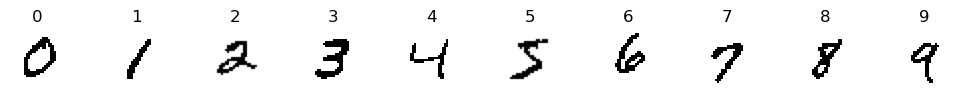

In [2]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [3]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.b = nn.Parameter(torch.zeros(n_visible))
        self.c = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.c)
        h_sample = torch.bernoulli(h_probs)
        return h_sample, h_probs

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.b)
        v_sample = torch.bernoulli(v_probs)
        return v_sample, v_probs

    def sample_gibbs(self, v0_sample, k=1):
        v = v0_sample
        for _ in range(k):
            h, _ = self.sample_hidden(v)
            v, _ = self.sample_visible(h)
        return v

    def free_energy(self, v):
        visible_term = v @ self.b
        hidden_term = nn.functional.softplus(v @ self.W + self.c).sum(dim=1)
        return -visible_term - hidden_term

In [19]:
def train_rbm(rbm, train_loader, num_epochs, k, optimizer, scheduler=None, pcd_reset=5):
    rbm.train()

    v_persistent = torch.bernoulli(torch.rand(batch_size, rbm.n_visible)).to(device)

    metrics = {}
    for epoch in range(num_epochs):
        total_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, rbm.n_visible).to(device)

            if batch_idx % pcd_reset == 0:
                v_persistent = torch.bernoulli(torch.rand(batch_size, rbm.n_visible)).to(device)

            v_k = rbm.sample_gibbs(v_persistent, k)
            v_persistent = v_k.detach()

            loss = rbm.free_energy(data).mean() - rbm.free_energy(v_k).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        metrics[epoch] = { "free_energy_loss": avg_loss }
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return metrics


#### TRAINING

batch_size      = 128
visible_units   = 28*28
hidden_units    = 256
k               = 1
lr              = 1e-3
num_epochs      = 30
pcd_reset       = 75        # reset persistent chain every N batches
weight_decay    = 1e-5      # L2 regularization
lr_decay        = 0.95      # learning rate decay PER EPOCH


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

rbm = RBM(visible_units, hidden_units).to(device)

optimizer = optim.Adam(rbm.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

metrics = train_rbm(rbm, train_loader, num_epochs=num_epochs, k=k, optimizer=optimizer, scheduler=scheduler, pcd_reset=pcd_reset)

Epoch [1/30] - Free Energy Loss: -80.1598
Epoch [2/30] - Free Energy Loss: -152.6705
Epoch [3/30] - Free Energy Loss: -208.6900
Epoch [4/30] - Free Energy Loss: -213.9374
Epoch [5/30] - Free Energy Loss: -195.9498
Epoch [6/30] - Free Energy Loss: -143.0412
Epoch [7/30] - Free Energy Loss: -131.4061
Epoch [8/30] - Free Energy Loss: -95.4876
Epoch [9/30] - Free Energy Loss: -88.5845
Epoch [10/30] - Free Energy Loss: -75.5125
Epoch [11/30] - Free Energy Loss: -74.6538
Epoch [12/30] - Free Energy Loss: -64.3406
Epoch [13/30] - Free Energy Loss: -62.8268
Epoch [14/30] - Free Energy Loss: -62.0037
Epoch [15/30] - Free Energy Loss: -62.0287
Epoch [16/30] - Free Energy Loss: -58.1476
Epoch [17/30] - Free Energy Loss: -60.6664
Epoch [18/30] - Free Energy Loss: -51.5074
Epoch [19/30] - Free Energy Loss: -49.2459
Epoch [20/30] - Free Energy Loss: -46.1299
Epoch [21/30] - Free Energy Loss: -47.5415
Epoch [22/30] - Free Energy Loss: -45.8458
Epoch [23/30] - Free Energy Loss: -44.7398
Epoch [24/30] 

Text(0, 0.5, 'Free Energy Loss')

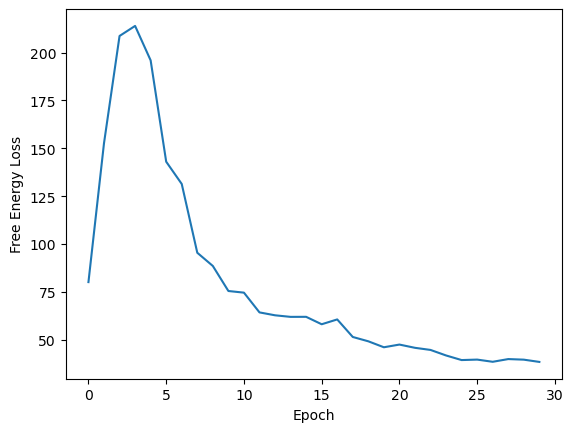

In [20]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [12]:
# store away model with timestamp and storehyperparameters in a small json for reference too:

import json
import os
import datetime

model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

# model name can be simple since we are storing hyperparameters in a json, just tag it by timestamp

model_name = f"rbm_mnist_pcd_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.pt"

torch.save(rbm.state_dict(), os.path.join(model_dir, model_name))

hyperparameters = {
    "visible_units": visible_units,
    "hidden_units": hidden_units,
    "k": k,
    "lr": lr,
    "num_epochs": num_epochs,
    "pcd_reset": pcd_reset,
    "weight_decay": weight_decay,
    "lr_decay": lr_decay }

with open(os.path.join(model_dir, model_name.replace(".pt", ".json")), "w") as f:
    json.dump(hyperparameters, f)

print(f"Model saved as {model_name}")

Model saved as rbm_mnist_pcd_20250325155229.pt


In [33]:
import json
import os

model_dir = "./models"

# load model back and check if it is working
model_name = "rbm_mnist_pcd_20250325155229.pt"
model_path = os.path.join(model_dir, model_name)

with open(model_path.replace(".pt", ".json"), "r") as f:
    hyperparameters = json.load(f)

rbm = RBM(hyperparameters["visible_units"], hyperparameters["hidden_units"]).to(device)
rbm.load_state_dict(torch.load(model_path))

print(f"Model loaded from {model_path}")


Model loaded from ./models/rbm_mnist_pcd_20250325155229.pt


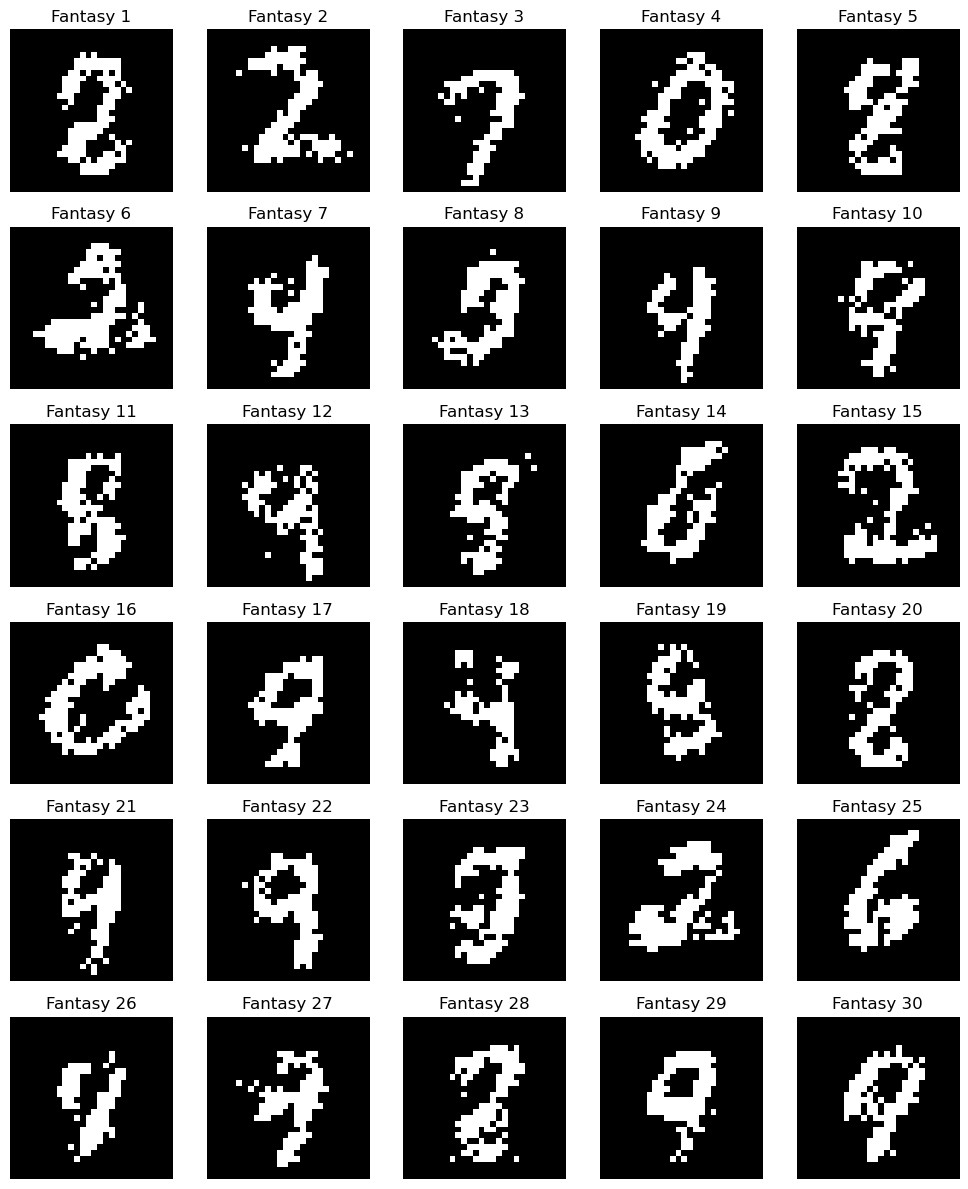

In [24]:
def sample_from_rbm(rbm, n_samples=16, n_steps=100):
    rbm.eval()

    v = torch.bernoulli(torch.rand(n_samples, rbm.n_visible)).to(device)
    with torch.no_grad():
        v = rbm.sample_gibbs(v, n_steps)
    return v.cpu().view(-1, 1, 28, 28)

#### GENERATION

fantasy_images = sample_from_rbm(rbm, n_samples=30, n_steps=50)
labeled_samples = [(f"Fantasy {idx+1}", img) for idx, img in enumerate(fantasy_images)]

print_samples(labeled_samples, elements_per_row=5, fig_width=10, cmap="gray")